## Nitrate above 15 m

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
    print (deptht)

[  0.50000027   1.50000314   2.5000115    3.50003055   4.50007042
   5.50015083   6.50031022   7.50062342   8.50123623   9.50243254
  10.5047653   11.50931127  12.51816684  13.53541212  14.56898216
  15.63428737  16.76117342  18.00713456  19.48178514  21.38997868
  24.10025665  28.22991514  34.68575798  44.51772486  58.48433368
  76.58558445  98.06295924 121.8665184  147.08945807 173.11448217
 199.57304923 226.26030574 253.06663733 279.93454976 306.83419736
 333.75016973 360.6745318  387.60320347 414.53408835 441.46610968]


In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [10]:
def plot_and_stats(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 0
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Nitrate between 15 and 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
def plot_and_stats_sal(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 35
    vmin = 20
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_vosaline[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.2), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= idepth], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity between 15 and 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

In [12]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2912,-4.1,6.8,0.085,0.35,0.62,5.3,4.3,-0.052


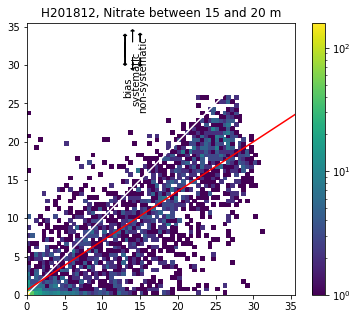

In [13]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 0
jdepth = 14
d201812 = plot_and_stats(temp1, 'H201812', idepth, jdepth)
d201812.style.format(myformat)

In [14]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,2912,-1.1,5.9,0.078,0.36,3.7,3.6,4.7,0.2


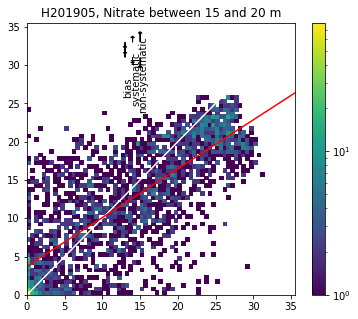

In [15]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])

d201905 = plot_and_stats(temp1, 'H201905', idepth, jdepth)
d201905.style.format(myformat)

In [16]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20160101-20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,2912,-3.7,6.5,0.085,0.37,1.2,5.1,4.1,0.083


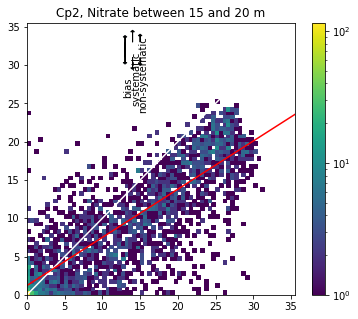

In [17]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
dCp2 = plot_and_stats(temp1, 'Cp2', idepth, jdepth)
dCp2.style.format(myformat)

In [18]:
pieces = ('/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PSF_20150701-20151231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PUG_20150701-20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,2892,-3.8,6.7,0.088,0.38,1.3,5.2,4.1,0.085


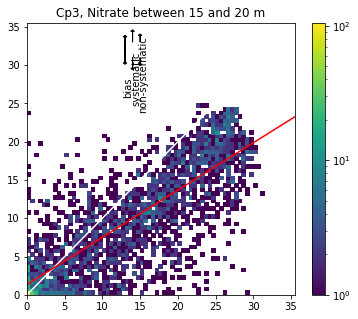

In [19]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
dCp3 = plot_and_stats(temp1, 'Cp3', idepth, jdepth)
dCp3.style.format(myformat)

In [20]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20170101_20171231.csv'
        )

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,2912,-1.7,5.7,0.074,0.37,3.2,3.9,4.2,0.21


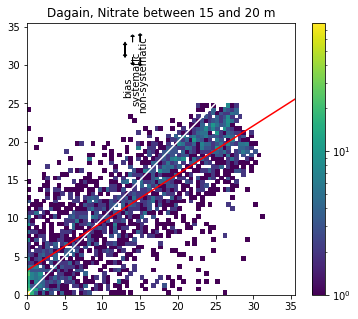

In [21]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
Dagain = plot_and_stats(temp1, 'Dagain', idepth, jdepth)
Dagain.style.format(myformat)

In [22]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20160101_20161231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,2912,-1.3,5.6,0.072,0.39,3.8,3.9,4.0,0.25


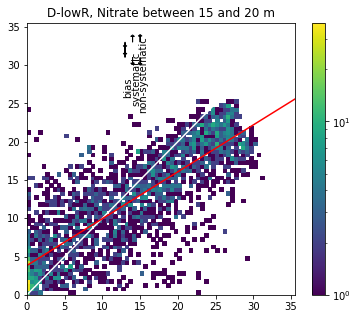

In [23]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
DlowR = plot_and_stats(temp1, 'D-lowR', idepth, jdepth)
DlowR.style.format(myformat)

In [24]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2912,-1.3,6.1,0.089,0.49,5.3,4.8,3.8,0.33


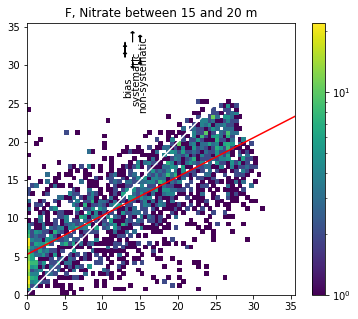

In [25]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

In [26]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [28]:
alltogether = pd.concat([d201812, d201905, dCp2, dCp3, Dagain, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2912,-4.1,6.8,0.085,0.35,0.62,5.3,4.3,-0.052
H201905,2912,-1.1,5.9,0.078,0.36,3.7,3.6,4.7,0.2
Cp2,2912,-3.7,6.5,0.085,0.37,1.2,5.1,4.1,0.083
Cp3,2892,-3.8,6.7,0.088,0.38,1.3,5.2,4.1,0.085
Dagain,2912,-1.7,5.7,0.074,0.37,3.2,3.9,4.2,0.21
D-lowR,2912,-1.3,5.6,0.072,0.39,3.8,3.9,4.0,0.25
F,2912,-1.3,6.1,0.089,0.49,5.3,4.8,3.8,0.33


In [50]:
temp1.set_index('dtUTC', inplace=True)
temp1.sort_index(inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='o', linewidth=0, label="Model (202007F)");
temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='x', linewidth=0, label= "Obs");

**Conclusion** Adding the variable rivers made the surface nitrate worse.  In particular, more of the time the model has near surface nitrate when the obs say it should be exhausted. Perhaps lower the nitrate half-sat?  Note that like all the models, the high nitrate values here are not high enough in the winter.

## D-again

In [55]:
temp1.set_index('dtUTC', inplace=True)
temp1.sort_index(inplace=True)

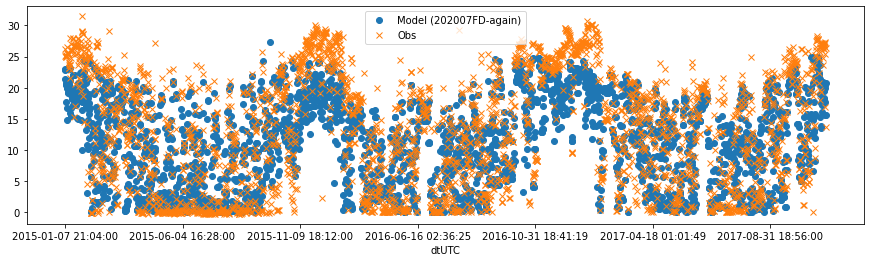

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='o', linewidth=0, label="Model (202007FD-again)");
temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='x', linewidth=0, label= "Obs");
ax.legend();

Much better in summer with flagellates!

## What about H201905?

In [60]:
temp1.set_index('dtUTC', inplace=True)
temp1.sort_index(inplace=True)

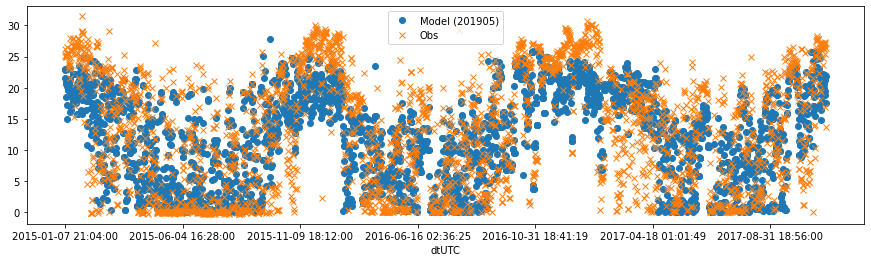

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='o', linewidth=0, label="Model (201905)");
temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='x', linewidth=0, label= "Obs");
ax.legend();

Same winter problem.

## Without Puget

In [69]:
temp1.set_index('dtUTC', inplace=True)
temp1.index = pd.to_datetime(temp1.index)
temp1.sort_index(inplace=True)

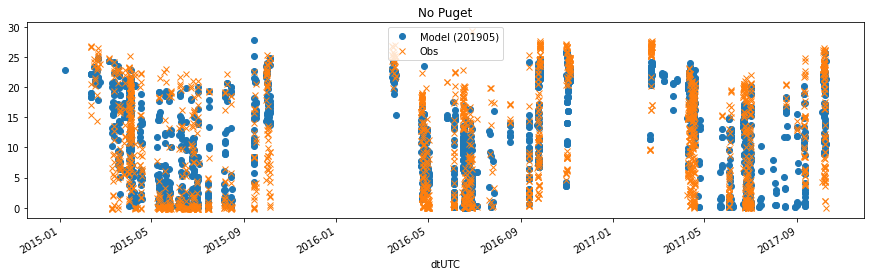

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='o', linewidth=0, label="Model (201905)");
temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='x', linewidth=0, label= "Obs");
ax.set_title('No Puget')
ax.legend();